# **DEEP LEARNING EXAM**

---


Name: NTEGANO Bahenda Yvon Dylan \
ID:     515657

# IMPORTS


Import of the libraries that will be used throughout the project.

In [ ]:
# ! pip install --upgrade tensorflow

# Sometimes errors were raised due to tensorflow version but it should not
# happen anymore.

In [ ]:
import urllib.request
import zipfile
import pickle as pk

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

# Don't Show Warning Messages
import warnings
warnings.filterwarnings('ignore')

# DATA LOADING

In [ ]:
# ZIP data URL from GitHub
zip_url = "https://github.com/dylanbahenda/DL-ANN/raw/main/input_data.zip"
# Download the ZIP
zip_path, _ = urllib.request.urlretrieve(zip_url)

# Unzip the folder
target_folder = "temp"

# Reading data
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(target_folder)
data_path = f"{target_folder}/input_data.pkl"

# Then use the following lines to read it:
with open(data_path, 'rb') as f:
   dd = pk.load(f)

X = dd['X']
y = dd['y']

## Data Visualization
I just take a look at the data to see its shape, the values of the features, and the target.
This is done just to see if the data is as expected.

In [ ]:
print(X.shape)
print(y.shape)

(303, 13)
(303, 1)


In [ ]:
X[:5]

array([[ 63. ,   1. ,   3. , 145. , 233. ,   1. ,   0. , 150. ,   0. ,
          2.3,   0. ,   0. ,   1. ],
       [ 37. ,   1. ,   2. , 130. , 250. ,   0. ,   1. , 187. ,   0. ,
          3.5,   0. ,   0. ,   2. ],
       [ 41. ,   0. ,   1. , 130. , 204. ,   0. ,   0. , 172. ,   0. ,
          1.4,   2. ,   0. ,   2. ],
       [ 56. ,   1. ,   1. , 120. , 236. ,   0. ,   1. , 178. ,   0. ,
          0.8,   2. ,   0. ,   2. ],
       [ 57. ,   0. ,   0. , 120. , 354. ,   0. ,   1. , 163. ,   1. ,
          0.6,   2. ,   0. ,   2. ]])

In [ ]:
y[:5]

array([[1],
       [1],
       [1],
       [1],
       [1]])

# 1. MODEL

The main architecture is an MLP, like it is said in the written solution, since it is most appropriate to deal with numeric vectors because it can be able to detect patterns in them.

The architecture is basically two hidden layers before the output. Each hidden layer is followed by a:

*   Batch Normalization layer, for stability and efficiency in training.

*   Dropout layer, to prevent overfitting.


As written in the solution, the activation function is "sigmoid" since all feature values in the input are in [0, 1]


This is just a snippet of how the architecture looks like, it refers to section 5, it will be seen latter.


<font color='red'>**CHANGE**</font>: I mentioned in the written solution that the number of units in the first hidden layer should be equal to the length of the input vector, which is not necessarily true. The number of units will be determined latter during hyperparameter tuning.

```
model = Sequential()

# First Dense layer with input shape
model.add(Dense(64, activation='sigmoid', input_shape=input_shape))
model.add(BatchNormalization())
model.add(Dropout(dropout_rate))

# Second Dense layer
model.add(Dense(32, activation='sigmoid'))
model.add(BatchNormalization())
model.add(Dropout(dropout_rate))

```



# 2. INPUT

## Preprocessing
Below we apply some preprocessing, as mentioned in the written solution, to make the data much more suitable for our model.
The preprocessing includes:

*   Transforming the dataset into a dataframe.
*   Applying a column transformer that applies min_max scaling to the numerical features, i.e columns 0, 3, 4, 7, 9, and it also performs one-hot encoding to the remaining categorical columns.


<font color='red'>**CHANGE**</font>:The dataframe transformation was not specifically mentioned in the written solution but it was needed to do it so as to apply the column transformer.



In [ ]:
dataframe = pd.DataFrame(X)
dataframe.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,63.0,1.0,3.0,145.0,233.0,1.0,0.0,150.0,0.0,2.3,0.0,0.0,1.0
1,37.0,1.0,2.0,130.0,250.0,0.0,1.0,187.0,0.0,3.5,0.0,0.0,2.0
2,41.0,0.0,1.0,130.0,204.0,0.0,0.0,172.0,0.0,1.4,2.0,0.0,2.0
3,56.0,1.0,1.0,120.0,236.0,0.0,1.0,178.0,0.0,0.8,2.0,0.0,2.0
4,57.0,0.0,0.0,120.0,354.0,0.0,1.0,163.0,1.0,0.6,2.0,0.0,2.0


In [ ]:
mmscaler = MinMaxScaler()
ohe = OneHotEncoder()

# Building the transformer
final_transformation = ColumnTransformer(
    transformers=[
        ('Numerical', mmscaler, [0, 3, 4, 7, 9]),
        ('Categorical', ohe, [1, 2, 5, 6, 8, 10, 11, 12])
    ],
    verbose_feature_names_out=False
)

# X_new is the transformed dataframe
X_new = final_transformation.fit_transform(dataframe)
X_new = pd.DataFrame(X_new, columns=final_transformation.get_feature_names_out())

In [ ]:
X_new.head()

,x0,x3,x4,x7,x9,x1_0.0,x1_1.0,x2_0.0,x2_1.0,x2_2.0,...,x10_2.0,x11_0.0,x11_1.0,x11_2.0,x11_3.0,x11_4.0,x12_0.0,x12_1.0,x12_2.0,x12_3.0
0,0.708333,0.481132,0.244292,0.603053,0.370968,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.166667,0.339623,0.283105,0.885496,0.564516,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.250000,0.339623,0.178082,0.770992,0.225806,1.0,0.0,0.0,1.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.562500,0.245283,0.251142,0.816794,0.129032,0.0,1.0,0.0,1.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.583333,0.245283,0.520548,0.702290,0.096774,1.0,0.0,1.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## Train/Test split

We split our dataframe into train and test splits, 70% and 30% respectively. We use the train set throughout the training process and we reserve the test set for latter during evaluation.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_new,
                                                    y,
                                                    test_size=0.3,
                                                    stratify =y,
                                                    random_state = 13)

In [ ]:
X_train.shape[1]

30

This is just to make sure that all values are between 0 and 1.

In [ ]:
print(f"Min and max feature values: {X_new.min()}, {X_new.max()}")

Min and max feature values: x0         0.0
x3         0.0
x4         0.0
x7         0.0
x9         0.0
x1_0.0     0.0
x1_1.0     0.0
x2_0.0     0.0
x2_1.0     0.0
x2_2.0     0.0
x2_3.0     0.0
x5_0.0     0.0
x5_1.0     0.0
x6_0.0     0.0
x6_1.0     0.0
x6_2.0     0.0
x8_0.0     0.0
x8_1.0     0.0
x10_0.0    0.0
x10_1.0    0.0
x10_2.0    0.0
x11_0.0    0.0
x11_1.0    0.0
x11_2.0    0.0
x11_3.0    0.0
x11_4.0    0.0
x12_0.0    0.0
x12_1.0    0.0
x12_2.0    0.0
x12_3.0    0.0
dtype: float64, x0         1.0
x3         1.0
x4         1.0
x7         1.0
x9         1.0
x1_0.0     1.0
x1_1.0     1.0
x2_0.0     1.0
x2_1.0     1.0
x2_2.0     1.0
x2_3.0     1.0
x5_0.0     1.0
x5_1.0     1.0
x6_0.0     1.0
x6_1.0     1.0
x6_2.0     1.0
x8_0.0     1.0
x8_1.0     1.0
x10_0.0    1.0
x10_1.0    1.0
x10_2.0    1.0
x11_0.0    1.0
x11_1.0    1.0
x11_2.0    1.0
x11_3.0    1.0
x11_4.0    1.0
x12_0.0    1.0
x12_1.0    1.0
x12_2.0    1.0
x12_3.0    1.0
dtype: float64


# 3. OUTPUT
Since the task is binary classification, the output layer is made of a single neuron which uses sigmoid as its activation function.




```
# Output layer (binary classification)
model.add(Dense(1, activation='sigmoid'))
```



# 4. LOSS
Binary Cross Entropy (BCE) is the ideal loss function in a binary classification task.



```
# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
```



# 5. MODEL CONFIGURATION

## Base Model
We create a base model to make sure our model works as intended and produces the correct kind of output.

In [ ]:
def build_base_model(input_shape, dropout_rate=0.5):
    """
    Builds the complete model by stacking Dense, Batch Normalization,
    and Dropout layers.

    Parameters:
    - input_shape (tuple): Shape of the input data.
    - dropout_rate (float): Dropout rate for each layer.

    Returns:
    - model (Sequential): A compiled Keras Sequential model.
    """
    model = Sequential()

    # First Dense layer with input shape
    model.add(Dense(64, activation='sigmoid', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))

    # Second Dense layer
    model.add(Dense(32, activation='sigmoid'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))

    # Output layer (binary classification)
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model


In [ ]:
# Build the base_model
input_shape = (X_train.shape[1],)  # Shape of the input data
base_model = build_base_model(input_shape=input_shape, dropout_rate=0.5)

In [ ]:
# Train the base_model
base_history = base_model.fit(X_train,
                    y_train,
                    epochs=20,
                    batch_size=16,
                    validation_split=0.1)

Epoch 1/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 220ms/step - accuracy: 0.4876 - loss: 0.8389 - val_accuracy: 0.5909 - val_loss: 0.6683
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6180 - loss: 0.7425 - val_accuracy: 0.5909 - val_loss: 0.6610
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6768 - loss: 0.6239 - val_accuracy: 0.5909 - val_loss: 0.6535
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7245 - loss: 0.5199 - val_accuracy: 0.5909 - val_loss: 0.6467
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8231 - loss: 0.3992 - val_accuracy: 0.7727 - val_loss: 0.6413
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7265 - loss: 0.4691 - val_accuracy: 0.7727 - val_loss: 0.6368
Epoch 7/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7782 - loss: 0.4707 - val_accuracy: 0.7727 - val_loss: 0.6313
Epoch 8/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8185 - loss: 0.4311 - val_accuracy: 0.7727 - val_los

## Hyperparameter Tuning
I decided to perform hyperparameter tuning manually due to some compatibility issues between Random Search CV and tensorflow. \






We define a function, build_model, that creates our model and allows the hyperparameters we want to optimize to be passed as parameters.










In [ ]:
# Define the model-building function
def build_model(units_1, units_2, dropout_rate, learning_rate):
    model = Sequential()
    model.add(Dense(units_1, activation='sigmoid', input_shape=(X_train.shape[1],)))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))

    model.add(Dense(units_2, activation='sigmoid'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))

    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Split data
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Define the hyperparameter space
dropout_rates = [0.3, 0.5]
learning_rates = [0.001, 0.0005]
batch_sizes = [16, 32]
units_1_options = [64, 128]
units_2_options = [32, 64]

# Variables to track best results
best_accuracy = 0
best_params = {}

# Manual tuning loop
for dropout_rate in dropout_rates:
    for learning_rate in learning_rates:
        for batch_size in batch_sizes:
            for units_1 in units_1_options:
                for units_2 in units_2_options:
                    # Build and train the model
                    model = build_model(units_1, units_2, dropout_rate, learning_rate)
                    history = model.fit(X_train_split, y_train_split, epochs=10, batch_size=batch_size, verbose=0, validation_data=(X_val_split, y_val_split))

                    # Evaluate the model
                    val_accuracy = np.max(history.history['val_accuracy'])

                    # Check if this model has the best validation accuracy
                    if val_accuracy > best_accuracy:
                        best_accuracy = val_accuracy
                        best_params = {
                            'dropout_rate': dropout_rate,
                            'learning_rate': learning_rate,
                            'batch_size': batch_size,
                            'units_1': units_1,
                            'units_2': units_2
                        }
                    print(f"Tested Params - dropout: {dropout_rate}, lr: {learning_rate}, batch: {batch_size}, units_1: {units_1}, units_2: {units_2} => Val Acc: {val_accuracy:.4f}")

# Print the best results
print(f"Best Validation Accuracy: {best_accuracy:.4f}")
print(f"Best Hyperparameters: {best_params}")


Tested Params - dropout: 0.3, lr: 0.001, batch: 16, units_1: 64, units_2: 32 => Val Acc: 0.4651
Tested Params - dropout: 0.3, lr: 0.001, batch: 16, units_1: 64, units_2: 64 => Val Acc: 0.5581
Tested Params - dropout: 0.3, lr: 0.001, batch: 16, units_1: 128, units_2: 32 => Val Acc: 0.6047
Tested Params - dropout: 0.3, lr: 0.001, batch: 16, units_1: 128, units_2: 64 => Val Acc: 0.5581
Tested Params - dropout: 0.3, lr: 0.001, batch: 32, units_1: 64, units_2: 32 => Val Acc: 0.4419
Tested Params - dropout: 0.3, lr: 0.001, batch: 32, units_1: 64, units_2: 64 => Val Acc: 0.4419
Tested Params - dropout: 0.3, lr: 0.001, batch: 32, units_1: 128, units_2: 32 => Val Acc: 0.6512
Tested Params - dropout: 0.3, lr: 0.001, batch: 32, units_1: 128, units_2: 64 => Val Acc: 0.5581
Tested Params - dropout: 0.3, lr: 0.0005, batch: 16, units_1: 64, units_2: 32 => Val Acc: 0.4651
Tested Params - dropout: 0.3, lr: 0.0005, batch: 16, units_1: 64, units_2: 64 => Val Acc: 0.5581
Tested Params - dropout: 0.3, lr: 

With hyperparameter tuning complete, we use the best parameters found to build our actual model.

In [ ]:
model = build_model(dropout_rate = best_params['dropout_rate'],
                    units_1 = best_params['units_1'],
                    units_2 = best_params['units_2'],
                    learning_rate = best_params['learning_rate'])

model.summary()

Model: "sequential_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_99 (Dense)                     │ (None, 128)                 │           3,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_66               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_66 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_100 (Dense)                    │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_67               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_67 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_101 (Dense)                    │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,057 (51.00 KB)

 Trainable params: 12,673 (49.50 KB)

 Non-trainable params: 384 (1.50 KB)

We, then, train our model on the train set to see its performance.

In [ ]:
history = model.fit(X_train,
                    y_train,
                    epochs=20,
                    batch_size=best_params['batch_size'],
                    validation_split=0.1)

Epoch 1/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 367ms/step - accuracy: 0.5563 - loss: 0.9738 - val_accuracy: 0.5909 - val_loss: 0.6608
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7632 - loss: 0.5651 - val_accuracy: 0.5909 - val_loss: 0.6483
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8095 - loss: 0.4734 - val_accuracy: 0.5909 - val_loss: 0.6417
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8079 - loss: 0.4930 - val_accuracy: 0.6364 - val_loss: 0.6393
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8084 - loss: 0.4381 - val_accuracy: 0.7727 - val_loss: 0.6400
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8045 - loss: 0.6129 - val_accuracy: 0.7727 - val_loss: 0.6405
Epoch 7/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8007 - loss: 0.4394 - val_accuracy: 0.7273 - val_loss: 0.6398
Epoch 8/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8569 - loss: 0.3936 - val_accuracy: 0.7727 - val_los

# 6. MODEL EVALUATION

## K-fold Cross Validation
We train our model, furthermore, by using K-fold cross validation to make it much more robust.\
The accuracy and loss of the 5 folds is averaged.

In [ ]:
def k_fold_cross_validation(X, y, k=5, epochs=20, batch_size=best_params['batch_size']):
    """
    Performs k-fold cross-validation on the model.

    Parameters:
    - X (numpy array): Feature data.
    - y (numpy array): Target labels.
    - k (int): Number of folds for cross-validation.
    - epochs (int): Number of epochs for training.
    - batch_size (int): Batch size for training.

    Returns:
    - average_accuracy (float): Average accuracy over all folds.
    - average_loss (float): Average loss over all folds.
    """
    # Initialize the KFold object
    kf = KFold(n_splits=k, shuffle=True, random_state=42)

    fold_accuracies = []
    fold_losses = []

    # Loop over each fold
    for fold_idx, (train_index, test_index) in enumerate(kf.split(X)):
        print(f"Training fold {fold_idx + 1}/{k}...")

        # Split data into train and validation sets for this fold
        X_train, X_val = X.iloc[train_index], X.iloc[test_index]
        y_train, y_val = y[train_index], y[test_index]

        # Build a new instance of the model for each fold
        model = build_model(dropout_rate = best_params['dropout_rate'],
                    units_1 = best_params['units_1'],
                    units_2 = best_params['units_2'],
                    learning_rate = best_params['learning_rate'])

        # Train the model
        history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val), verbose=0)

        # Evaluate the model on the validation data
        val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)

        # Save the accuracy and loss for this fold
        fold_accuracies.append(val_accuracy)
        fold_losses.append(val_loss)

    # Calculate the average accuracy and loss over all folds
    average_accuracy = np.mean(fold_accuracies)
    average_loss = np.mean(fold_losses)

    print(f"\nAverage Accuracy over {k} folds: {average_accuracy:.4f}")
    print(f"Average Loss over {k} folds: {average_loss:.4f}")

    return average_accuracy, average_loss


In [ ]:
k = 5  # Number of folds
epochs = 20
batch_size = best_params['batch_size']

# Perform k-fold cross-validation
avg_accuracy, avg_loss = k_fold_cross_validation(X_train, y_train, k=k, epochs=epochs, batch_size=batch_size)


Training fold 1/5...
Training fold 2/5...
Training fold 3/5...
Training fold 4/5...
Training fold 5/5...

Average Accuracy over 5 folds: 0.7971
Average Loss over 5 folds: 0.5340


## Test Set Performance
To measure the generalization capabilities of the model on unseen data, we evaluate it on the test set that we reserved earlier.

This test set is previously unseen by the model.

In [ ]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 246ms/step - accuracy: 0.7894 - loss: 0.4858
Test Accuracy: 81.32%


## Visualization
Below we will plot the learning curve and confusion matrix.

The learning curve is plotted so that we can observe the way the model behaves during training and it can also tell us wether there is overfitting or not.


The confusion matrix is useful to visualize the classification results.


In [ ]:
def plot_confusion_matrix(model, X_test, y_test):
    # Get predictions from the model
    y_pred = model.predict(X_test)
    y_pred_classes = (y_pred > 0.5).astype("int32")  # Convert probabilities to binary predictions

    # Calculate confusion matrix
    cm = confusion_matrix(y_test, y_pred_classes)

    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()


In [ ]:
def plot_learning_curve(history):
    # Get training and validation metrics from history
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Plot accuracy learning curve
    plt.figure(figsize=(12, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Learning Curve (Accuracy)')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Learning Curve (Loss)')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


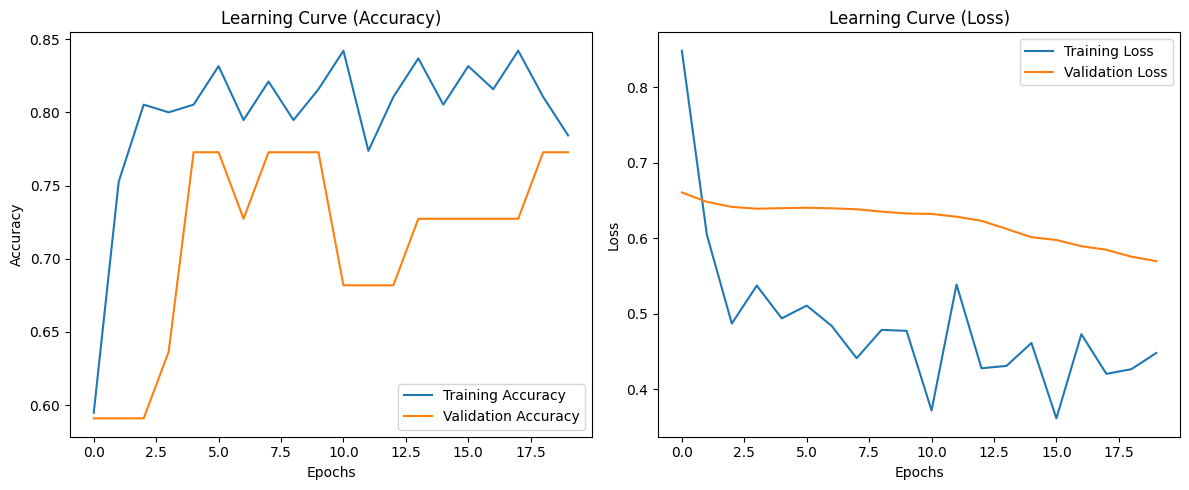

In [ ]:
# Plot learning curve
plot_learning_curve(history)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 333ms/step


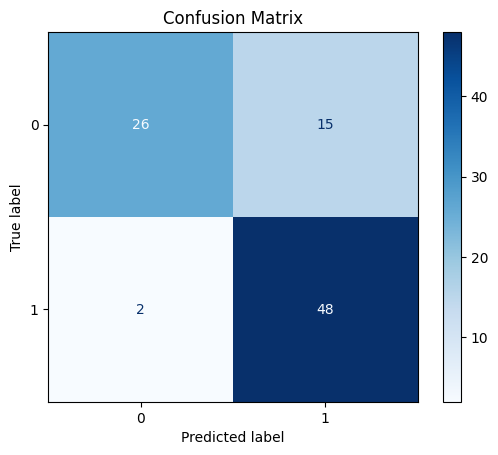

In [ ]:
# Plot confusion matrix for the test set
plot_confusion_matrix(model, X_test, y_test)

# 7. MODEL INTERPRETATION


For interpreting the model and explain the prediction results, I used saliency maps because they highlight how individual input features influence the model's prediction by backtracking through the network. They compute the gradient of the output with respect to the input, and this effectively shows which input features caused the greatest change in the output. This reflects how the weights of neurons in the network interact with the input features.







<font color='red'>CHANGE</font>: In the written solution it was not specifically written that I would use saliency maps. However, as explained above, they work by backtracking through the network and also their working reflects how the neuron weights are associated with the input which is what I mentioned in the written solution.

In [ ]:
# Define a function to compute saliency map
def compute_saliency(model, sample):
    with tf.GradientTape() as tape:
        tape.watch(sample)  # Watch the input for gradients
        prediction = model(sample)

    # Compute the gradient of the predicted class with respect to the input
    gradient = tape.gradient(prediction, sample)

    # Take the absolute value of the gradient
    saliency = np.abs(gradient)

    return saliency

# Select a sample from the test set and convert to Tensor
sample_idx = 0
sample = X_test.iloc[sample_idx:sample_idx + 1]  # Assuming X_test is a DataFrame

# Convert the sample to a NumPy array or Tensor
sample_array = np.array(sample)
sample_tensor = tf.convert_to_tensor(sample_array, dtype=tf.float32)

# Compute the saliency map
saliency_map = compute_saliency(model, sample_tensor)

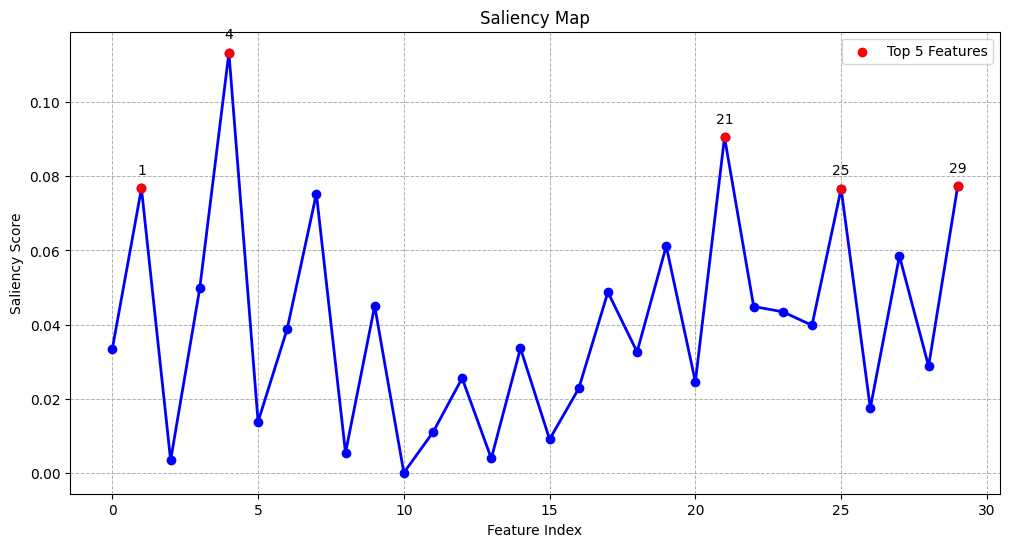

In [ ]:
# Define feature indices
feature_indices = np.arange(saliency_map.shape[1])

# Plot the saliency map
plt.figure(figsize=(12, 6))
plt.plot(feature_indices, saliency_map[0], color='blue', marker='o', linestyle='-', linewidth=2, markersize=6)

# Highlight important features (e.g., top 5 features)
top_features = np.argsort(saliency_map[0])[-5:]  # Indices of top 5 features
plt.scatter(top_features, saliency_map[0][top_features], color='red', zorder=5, label='Top 5 Features')

# Annotate top features
for idx in top_features:
    plt.annotate(f'{idx}', (idx, saliency_map[0][idx]), textcoords="offset points", xytext=(0,10), ha='center')

# Add gridlines
plt.grid(True, which='both', linestyle='--', linewidth=0.7)

# Add labels and title
plt.title('Saliency Map')
plt.xlabel('Feature Index')
plt.ylabel('Saliency Score')

# Add a legend
plt.legend()

# Show the plot
plt.show()


# CONCLUSION

In conclusion, the model works well and it is able to predict the classes associated with the input.


The model can be improved by increasing its complexity, optimizing more parameters, and increasing the number of epochs.

